<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#使用手寫辨識資料集,-觀察-PCA-算法" data-toc-modified-id="使用手寫辨識資料集,-觀察-PCA-算法-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>使用手寫辨識資料集, 觀察 PCA 算法</a></span></li><li><span><a href="#[教學目標]" data-toc-modified-id="[教學目標]-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>[教學目標]</a></span></li><li><span><a href="#[範例重點]" data-toc-modified-id="[範例重點]-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>[範例重點]</a></span></li><li><span><a href="#觀察結果" data-toc-modified-id="觀察結果-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>觀察結果</a></span></li></ul></div>

# 使用手寫辨識資料集, 觀察 PCA 算法

# [教學目標]
- 以 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化
- 因為非監督模型的效果, 較難以簡單的範例看出來  
  所以非監督偶數日提供的範例與作業, 主要目的在於觀察非監督模型的效果,  
  同學只要能感受到模型效果即可, 不用執著於搞懂程式的每一個部分

# [範例重點]
- 以手寫辨識資料集, 觀察 PCA 算法取不同 component 時, PCA 解釋度與分類正確率如何變化 (In[5], Out[5])

In [1]:
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 定義 PCA 與隨後的邏輯斯迴歸函數
logistic = SGDClassifier(loss='log', penalty='l2', max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# 載入手寫數字辨識集
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

In [3]:
pipe

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logistic',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='log',
                               max_iter=10000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=0,
                               shuffle=True, tol=1e-05, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [3]:
# 先執行 GridSearchCV 跑出最佳參數
param_grid = {
    'pca__n_components': [4, 10, 20, 30, 40, 50, 64],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=False)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.920):
{'logistic__alpha': 0.01, 'pca__n_components': 64}


NameError: name 'search' is not defined

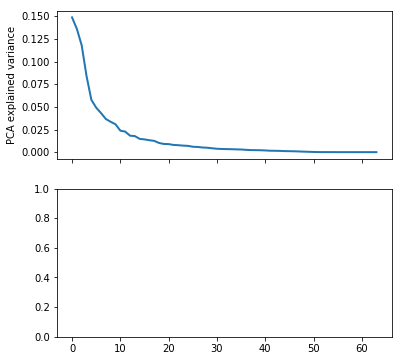

In [7]:
# 繪製不同 components 的 PCA 解釋度
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))


In [8]:
# 繪製不同採樣點的分類正確率
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')
plt.tight_layout()
plt.show()

NameError: name 'search' is not defined

# 觀察結果
* explained variance ratio : 解釋變異性隨著 components 穩定下降
* 分類預測準確率 : 似乎也隨著 components 提升, 但是在 20 以後提升不多